# SMV2rho: Tutorial 4

In this tutorial we will convert from velocity to density using the new `SMV2rho` approach, which is outlined in Stephenson et al (_in review_)

First let's import the required modules from `SMV2rho`

In [1]:
# import modules
from SMV2rho import plotting as smplt
from SMV2rho import density_functions as smd

## Class approach

Again we will first go through this procedure step-by-step so that we can query the outputs.

### Load file

Let's define the velocity profile that we are interested in converting, initialise the `Convert` class and read in the profile data file.

In [2]:
# path to test velocity file
#  - this file comes with the distribution so there is no need to change this path
vp_file = "../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat"

# load a profile into the Convert class
profile = smd.Convert(vp_file, profile_type = "Vp")

# read data
profile.read_data()

### Convert profile

Now we can convert the profile into density.  To do this, we need to load in the parameter file.  Initially, we will set all arguments to default.  We will not include temperature dependence or compressibility for now.

The parameter file must have the following format (pleae refer to Stephenson et al (_in review_) for details on parameter definitions.

parameters $ =[v_0, b, d_0, d_P, c, k]$

In [3]:
import numpy as np

# import parameter data
parameter_file = "../PARAMETER_FILES/Vp_parameters.dat"
parameters = np.loadtxt(parameter_file)

Let's now attempt to run this function.  This will generate a `ValueError`, because the default setup of the function is to include temperature dependence, which requires parameters to be provided.  Since we have not provided the parameter file, attempting to run this function will throw an error.

In [4]:
# calculate density profile -- note default is the temperature dependence is True!
profile.V_to_density_stephenson(parameters)

ValueError: T_dependence is set to True but T_parameters have not been set

We will now provide the information that `T_dependence = False`.  This added optional argument will suppress the above error and allow the program to run.  Note that in doing this we are assuming that $V$ and $\rho$ are both unaffected by temperature, $T$, and that we don't need to account for compressibility.

Running this function may result in an integration warning.  This warning can be safely ignored and is generated because the velocity and density profile functions $V_P(z)$ and $\rho (z)$ contain discontinuities.

In [5]:
# calculate density profile -- note default is the temperature dependence is True!
profile.V_to_density_stephenson(parameters, T_dependence = False)

profile.data.keys()

/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1544: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


dict_keys(['station', 'Vp_file', 'region', 'moho', 'location', 'av_Vp', 'Vp', 'type', 'method', 'rho', 'av_rho', 'rho_hi_res', 'Vp_hi_res', 'p'])

### Outputs and plotting

We now have a number of new fields that have appeared in our `profile.data` dictionary.  We have, as before, `'rho'` and `'av_rho'` fields, but now we also have `'rho_hi_res'`, `'Vp_hi_res'` and `'p'` fields.  These fields are generated because the velocity profile must be discretized in order to calculate pressure, $p$ as a function of depth, which is in turn needed for the density conversion.  Let's have a look at them.

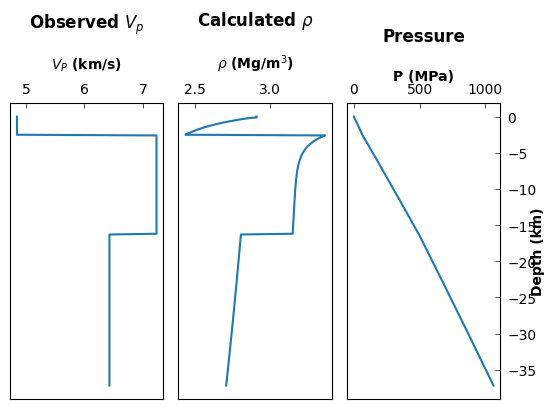

In [6]:
# Define plot settings
plot_type = 'line'
titles = [r'Observed ${V_p}$', r'Calculated $\rho$', 'Pressure']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^3}$)', 'P (MPa)']
ylabels = ['Depth (km)', 'Depth (km)', 'Depth (km)']

# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile.data["Vp_hi_res"][:,1], 'y': profile.data["Vp_hi_res"][:,0]}]
data2 = [{'x': profile.data["rho_hi_res"][:,1], 'y': profile.data["rho_hi_res"][:,0]}]
data3 = [{'x': profile.data["p"][:,1], 'y': profile.data["p"][:,0]}]

# Call the plot_panels function
smplt.plot_panels([data1, data2, data3], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=0.7, 
            save_path=None)

We see that $\rho(z)$ is now varing within layers.  this behaviour arises because the `SMV2rho` density conversion scheme is pressure-dependent.  Density is binned into the same depth intervals as the velocity profile during the conversion process adn we can take a look at that below with the `'rho'` key...

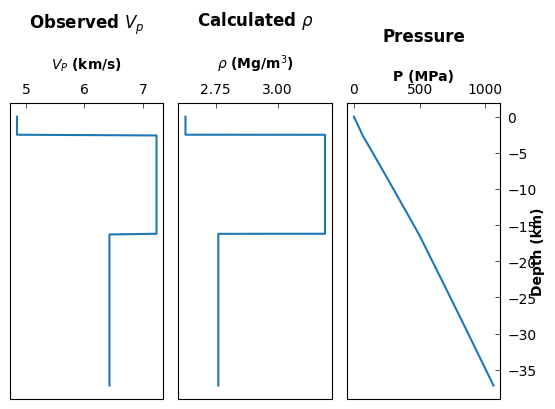

In [7]:
# Define plot settings
plot_type = 'line'
titles = [r'Observed ${V_p}$', r'Calculated $\rho$', 'Pressure']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^3}$)', 'P (MPa)']
ylabels = ['Depth (km)', 'Depth (km)', 'Depth (km)']

# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile.data["Vp_hi_res"][:,1], 'y': profile.data["Vp_hi_res"][:,0]}]
data2 = [{'x': profile.data["rho"][:,1], 'y': profile.data["rho"][:,0]}]
data3 = [{'x': profile.data["p"][:,1], 'y': profile.data["p"][:,0]}]

# Call the plot_panels function
smplt.plot_panels([data1, data2, data3], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=0.7, 
            save_path=None)

Notice the resolution of the density profile is now the same as the velocity profile.  This functionality only works well if the velocity profile does not have vertical gradients within layers.

## Function approach

Again, we can achieve the same outcome by running a wrapper function if users find this approach easier.  Again, we lose some granularity in accessing the class outputs but it may be more straightforward to follow.

We will set `approach = 'stephenson'` and give the programme the parameter file.

In [10]:
# call density conversion function
# note that using profile_type="Vs" first calls a function to convert to Vp
# as is required by Brocher's (2005) approach.
profile_stephenson = smd.convert_V_profile(vp_file, 
                            profile_type="Vp", 
                            approach="stephenson",
                            working_file = True,
                            parameters = parameters)

# print the keys to check that the outputs are identical to the class method
profile_stephenson.keys()

working on ../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat


dict_keys(['station', 'Vp_file', 'region', 'moho', 'location', 'av_Vp', 'Vp', 'type', 'method', 'rho', 'av_rho', 'rho_hi_res', 'Vp_hi_res', 'p'])

We can now check the output again by plotting...

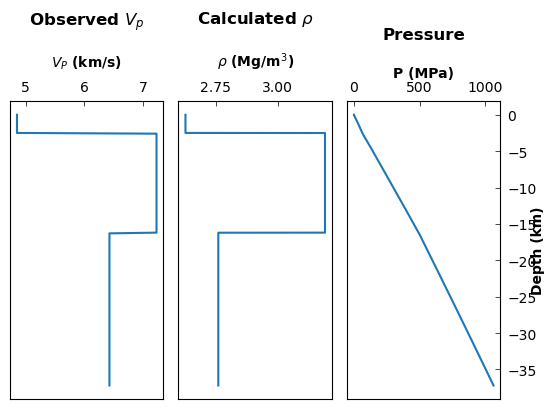

In [11]:
# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile_stephenson["Vp_hi_res"][:,1], 'y': profile_stephenson["Vp_hi_res"][:,0]}]
data2 = [{'x': profile_stephenson["rho"][:,1], 'y': profile_stephenson["rho"][:,0]}]
data3 = [{'x': profile_stephenson["p"][:,1], 'y': profile_stephenson["p"][:,0]}]

# Call the plot_panels function
smplt.plot_panels([data1, data2, data3], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=0.7, 
            save_path=None)

## Summary

We have converted a Vp file to density using the `SMV2rho`, or `stephenson` approach without including any temperature dependence.  We have explored approaches to carrying out this conversion using both a class- and method-based approach.  We have checked that the outputs from these two approaches in the same by plotting.